TUTORIAL 4 : GCMC Lennard-Jones
===============================

Original authors: James Grant (r.j.grant{at}bath.ac.uk), Tom L. Underwood (t.l.underwood{at}bath.ac.uk)

Modified to use dlmontepython by Joe Manning (joseph.manning{at}manchester.ac.uk)


Introduction
------------

Grand Canonical Monte Carlo (GCMC) is so named because it allows sampling from the grand canonical ensemble.  
In NVT we couple the simulation to a thermostat, with which the system exchanges energy at constant temperature.
Similarly with NPT we introduce a barostat which allows volume exchange at constant pressure.
GCMC marks a distinction from ensembles that can be modelled with molecular dynamics (MD) because we now allow particles to be added or deleted from the system.
This exchange happens at constant *chemical potential* $\mu$ and the ensemble is alternatively known as 
$\mu\mathrm{VT}$ since volume and temperature are also held constant.
The total energy, $E$ of the system is now defined as


$$
  E=U(\underline{r})+\mu N
$$
where $U(\underline{r})$ is the energy of the configuration and *N* the number of particles.

Inputs
------

### Setting up the CONTROL file 

The CONTROL file is a bit different in GCMC compared to NVT or NVP MC. We'll modify our control file as below.

```
   GCMC Lennard-Jones 
   finish
   seeds 12 34 56 78               # Seed RNG seeds explicitly to the default
   temperature     1.4283461511745 # Corresponds to T*=1.1876; 
                                   # T(in K) = T* / BOLTZMAN 

   steps          10000            # Number of moves to perform in simulation
   equilibration    0              # Equilibration period: statistics 
                                   # are gathered after this period
   print           1000            # Print statistics every 'print' moves
   stack           1000            # Size of blocks for block averaging to obtain statistics
   sample coord   10000            # How often to print configurations to ARCHIVE.000
   revconformat dlmonte            # REVCON file is in DL_MONTE CONFIG format
   archiveformat dlpoly4           # ARCHIVE.000/HISTORY.000/TRAJECTORY.000 format 
                                   # In this case: HISTORY.000 in DLPOLY4 style
   yamldata 1000
   move gcinsertmol 1 100 0.7      # Perform insertion/removal moves for lj, a weight 100
                                   # with a min. distance of 0.7 from atoms for inserts
   lj  0.06177                     # Use an activity of 0.06177   
   #  move atom 1 512                 # Move atoms with a weight of 512
   #  LJ core 
   #  move volume cubic linear 1      # Move volume, box is cubic, 
   #                                # linear scaling with a weight of 1
   start
```
You'll first notice we removed the directives that switch on the neighbour lists *nbrlist* and *maxnonbondnbrs* (and *verlet*).
The cost of maintaining the list in GCMC negates the benefits when calculating the energy.
In this calculation DL_MONTE is using the activity *a* rather than the chemical potential $\mu$,
which are related according to 

$$
a = \exp(\mu/RT)
$$

where *R* is the gas constant.
Note that the grand-canonical insert/delete moves are performed on the *molecule* level.

Here we have turned off atom translation moves though there is nothing in principle wrong with allowing these types of moves.
However in order to work in the $\mu\mathrm{VT}$ ensemble volume moves *MUST* be switched off.
Consider what could happen if both insert/deletes and volume moves were allowed.
The acceptance rule for linear displacement using the Metropolis approach for insertions is:

$$
P_{\mathrm{acc}}([\mathbf{r}_1,N_1] \rightarrow [\mathbf{r}_2,N_2] ) = \min(1,  \frac{V\Lambda^{-3}}{N+1} \exp \{- \beta [E(\mathbf{r}_2,N_2) - E(\mathbf{r}_1,N_1)] \} )
$$
and for deletions is:

$$
  P_{\mathrm{acc}}([\mathbf{r}_1,N_1] \rightarrow [\mathbf{r}_2,N_2] ) = \min(1,  \frac{N}{V\Lambda^{-3}}\exp \{- \beta [E(\mathbf{r}_2,N_2) - E(\mathbf{r}_1,N_1)] \} )
$$

#### Exercise 1: setup the CONTROL file now in the `Tutorial_4` directory using dlmontepython.
> Hint, refer to the previous tutorials for code to be reused, or entire CONTROL files to read in and modify! 

In [1]:
from dlmontepython.htk.sources import dlcontrol
# Your code here!

### The FIELD and CONFIG files
The FIELD and CONFIG files need slight changes compared to tutorial 3 in order to work with GCMC in DL_MONTE.
First we will consider the FIELD file:

```
   Lennard-Jones, 2.5*sigma cut-off, sigma = 1 angstrom, epsilon = 1eV
   CUTOFF 2.5
   UNITS internal
   NCONFIGS 1
   ATOMS 1
   LJ core 1.0  0.0
   MOLTYPES 1
   lj
   ATOMS 1 1
   LJ core 0.0 0.0 0.0
   FINISH
   VDW 1
   LJ core  LJ core lj   1.0 1.0
   CLOSE
```
Although the *cutoff* and *units* and number of configurations *nconfigs* remain the same as in NVT and NPT exercises, and there is still 1 atom type and 1 molecule type, the FIELD the block declaring the *molecules* is different from what was used previously.

In the NVT and NPT cases all the particles were declared to be part of the same molecule. In GCMC each particle should be considered a `molecule` in its own right. To this end, the *maxatom* directive that we used before is now replaced with another directive: `*atoms <initial atoms> <max atoms>*` which provides a template for the atoms' coordinates (if there were more atoms in a molecule then the coordinates for all of them would have to be specified).

In principle atoms can be added or removed from a molecule. However in the cases we will consider only molecule will be inserted or deleted, so molecules will have a fixed number of particles, in this case 1. We also define an archetype of the molecule listing the atoms comprising the molecule and their relative coordinates. Again, since we have a single Lennard--Jones particle in each molecule we simply position it at the origin of the reference molecule. The molecule entry is completed with the *finish* directive and the file is completed with the interactions, in this case a single *vdw* interaction as before.

Turning to the CONFIG, this is also altered to take account of the changes in the molecule declaration given in the FIELD file:

```
   Lennard-Jones starting configuration rho = 0.125; particles are molecules, not atoms
         0         1
   10.0000000000000000  0.0000000000000000  0.0000000000000000
   0.0000000000000000  10.0000000000000000  0.0000000000000000
   0.0000000000000000  0.0000000000000000  10.0000000000000000
   NUMMOL 8 1000
   MOLECULE lj 1 1
   LJ   core
   -5.0000000000000000 -5.0000000000000000 -5.0000000000000000 
   MOLECULE lj 1 1
   LJ   core
   0.0000000000000000 -5.0000000000000000 -5.0000000000000000 
   etc
```
The molecule declaration mirrors that seen in the FIELD file.
Each particle must be declared as part of a molecule along with its type and initial and maximum numbers of atoms.
The atom/particle declaration and its position then follows as before.

#### Exercise 2: Set up CONFIG and FIELD files using dlmontepython

In [2]:
from dlmontepython.htk.sources import dlfield, dlconfig
# your code here!

Analysing the outputs
---------
Launch DL_MONTE as you did in the previous tutorial. Again, we'll use dlmontepython to analyse the results from the YAMLDATA file.

In [6]:
from dlmontepython.htk.sources import dlptfile
import pandas as pd

yaml_out = dlptfile.load_yaml('./Tutorial_4_files/')
yaml_df = pd.DataFrame(yaml_out.data)
yaml_df
#yaml_df = yaml_df.set_index('timestamp')
#yaml_df.plot.line(y='nmols')

,timestamp,energy,energyvdw,nmol
0,1000,-6.000009e+07,-6.000009e+07,[107]
1,2000,-6.000014e+07,-6.000014e+07,[132]
2,3000,-6.000023e+07,-6.000023e+07,[176]
3,4000,-6.000020e+07,-6.000020e+07,[166]
4,5000,-6.000021e+07,-6.000021e+07,[172]
5,6000,-6.000023e+07,-6.000023e+07,[167]
6,7000,-6.000028e+07,-6.000028e+07,[191]
7,8000,-6.000025e+07,-6.000025e+07,[178]
8,9000,-6.000023e+07,-6.000023e+07,[170]
9,10000,-6.000025e+07,-6.000025e+07,[176]


You'll ntice that instead of being an integer, 'nmol' here is a list. This comes in handy when you have multiple molecules - the index of the list matches the order they're defined in the `FIELD` file.

To make use of the information, we need to change the data type with df.apply

<AxesSubplot:xlabel='timestamp'>

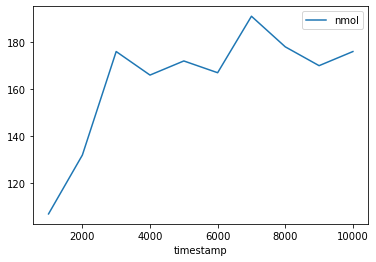

In [13]:
yaml_df.nmol = yaml_df['nmol'].apply(lambda x: int(x[0]))
yaml_df = yaml_df.set_index('timestamp')
yaml_df.plot.line(y='nmol')

From this, we extract the time sequence of the number of particles in the system. 

#### Challenge 1 - testing equilibration
Does the system look equilibrated to you? How can we assess this quantitiatively? First, try increasing the length of the simulation to establish whether the system has equilibrated. Then, can you apply the algorithms in [this paper](https://pubs.acs.org/doi/10.1021/acs.jctc.5b00784)? Hint - check out the `timeseries module` in their [python package](https://pymbar.readthedocs.io/en/master/).

#### Challenge 2 - the effect of different parameters

What happens as you systematically vary the temperature and activity (chemical potential)?  
You can  explore histograms once you have produced the time sequence of adsorbed particles with `plot.hist()` method of the resulting dataframe.

In [ ]:
# Your code here!